# Optimization Methods, Lab №3


## Acknowledgments

- Tovmasian Arman M3232
- Kister Artemii M3232
- Khimchenko Maxim M3232

## Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import seaborn as sns
import pandas as pd
import tensorflow as tf
import logging

from sklearn.datasets import make_regression
from memory_profiler import memory_usage

## Common SGD function

In [12]:
def sgd_optimizer(X, y, lr=0.01, epochs=100, batch_size=32, optimizer='sgd', lr_schedule=None, **kwargs):
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)
    history = []

    if optimizer == 'momentum':
        momentum = kwargs.get('momentum', 0.9)
        v = np.zeros(n_features)
    elif optimizer == 'nesterov':
        momentum = kwargs.get('momentum', 0.9)
        v = np.zeros(n_features)
    elif optimizer == 'adagrad':
        epsilon = kwargs.get('epsilon', 1e-8)
        G = np.zeros(n_features)
    elif optimizer == 'rmsprop':
        beta = kwargs.get('beta', 0.9)
        epsilon = kwargs.get('epsilon', 1e-8)
        E_g2 = np.zeros(n_features)
    elif optimizer == 'adam':
        beta1 = kwargs.get('beta1', 0.9)
        beta2 = kwargs.get('beta2', 0.999)
        epsilon = kwargs.get('epsilon', 1e-8)
        m = np.zeros(n_features)
        v = np.zeros(n_features)

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            gradients = -2 / len(X_batch) * X_batch.T.dot(y_batch - X_batch.dot(theta))
            
            if optimizer == 'sgd':
                if lr_schedule:
                    lr = lr_schedule(epoch * n_samples // batch_size + i // batch_size)
                theta -= lr * gradients
            
            elif optimizer == 'momentum':
                if lr_schedule:
                    lr = lr_schedule(epoch * n_samples // batch_size + i // batch_size)
                v = momentum * v - lr * gradients
                theta += v

            elif optimizer == 'nesterov':
                if lr_schedule:
                    lr = lr_schedule(epoch * n_samples // batch_size + i // batch_size)
                theta_lookahead = theta + momentum * v
                gradients = -2 / len(X_batch) * X_batch.T.dot(y_batch - X_batch.dot(theta_lookahead))
                v = momentum * v - lr * gradients
                theta += v

            elif optimizer == 'adagrad':
                G += gradients**2
                adjusted_lr = lr / (np.sqrt(G) + kwargs.get('epsilon', 1e-8))
                theta -= adjusted_lr * gradients

            elif optimizer == 'rmsprop':
                E_g2 = beta * E_g2 + (1 - beta) * gradients**2
                adjusted_lr = lr / (np.sqrt(E_g2) + kwargs.get('epsilon', 1e-8))
                theta -= adjusted_lr * gradients

            elif optimizer == 'adam':
                t = epoch * n_samples // batch_size + i // batch_size + 1
                m = beta1 * m + (1 - beta1) * gradients
                v = beta2 * v + (1 - beta2) * gradients**2
                m_hat = m / (1 - beta1**t)
                v_hat = v / (1 - beta2**t)
                theta -= lr * m_hat / (np.sqrt(v_hat) + kwargs.get('epsilon', 1e-8))

        loss = np.mean((y - X.dot(theta))**2)
        history.append(loss)

    return theta, history

## TF Implementation

In [17]:
n = 100  
a = 3    
b = 5    
noise = 1.0

dots = generate_dots_simple(n, a, b, noise)
X = dots[:, 0].reshape(-1, 1)
y = dots[:, 1]


def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, input_shape=(1,))
    ])
    return model


h = 0.01
optimizers = [
    tf.keras.optimizers.SGD(learning_rate=h),
    tf.keras.optimizers.SGD(learning_rate=h, momentum=0.9),
    tf.keras.optimizers.SGD(learning_rate=h, momentum=0.9, nesterov=True),
    tf.keras.optimizers.Adagrad(learning_rate=h),
    tf.keras.optimizers.RMSprop(learning_rate=h),
    tf.keras.optimizers.Adam(learning_rate=h)
]

results = []

for optimizer in optimizers:
    model = create_model()
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    start_mem = memory_usage(-1, interval=1, timeout=1)
    start_time = time.time()
    
    model.fit(X, y, epochs=100, verbose=0)
    
    end_time = time.time()
    end_mem = memory_usage(-1, interval=1, timeout=1)
    
    memory_used = max(end_mem) - max(start_mem)
    time_taken = end_time - start_time
    weights = model.get_weights()[0].flatten()

    print(optimizer.get_config()['name'], memory_used, time_taken, weights)
    results.append({
        'Optimizer': optimizer.get_config()['name'],
        'Memory Used (MB)': memory_used,
        'Time Taken (seconds)': time_taken,
        'Weights': weights
    })

df_results = pd.DataFrame(results)
df_results

2024-05-29 19:34:41.461739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-29 19:34:41.478612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


SGD 24.15234375 2.0550737380981445 [2.9986255]


2024-05-29 19:34:45.535060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-29 19:34:45.550269: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


SGD 22.73046875 1.9260332584381104 [3.2107778]


2024-05-29 19:34:49.505542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-29 19:34:49.522826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


SGD 21.359375 1.9175429344177246 [2.8867278]


2024-05-29 19:34:53.450996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Adagrad 31.66796875 2.534834861755371 [-0.46353182]


2024-05-29 19:34:58.025526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


RMSprop 35.578125 2.5417890548706055 [2.965326]


2024-05-29 19:35:02.627034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-29 19:35:02.648615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


Adam 26.91796875 2.213521718978882 [2.8951044]


,Optimizer,Memory Used (MB),Time Taken (seconds),Weights
0,SGD,24.152344,2.055074,[2.9986255]
1,SGD,22.730469,1.926033,[3.2107778]
2,SGD,21.359375,1.917543,[2.8867278]
3,Adagrad,31.667969,2.534835,[-0.46353182]
4,RMSprop,35.578125,2.541789,[2.965326]
5,Adam,26.917969,2.213522,[2.8951044]


## Data generation

In [5]:
def generate_dots_simple(n, a, b, noise=1.0):
    X = np.linspace(-10, 10, n)
    y = a * X + b + np.random.normal(scale=noise, size=n)
    return np.vstack((X, y)).T


def exact_ans(dots):
    """Функция для линейной регрессии (для расчета истинного решения)"""
    X = dots[:, 0]
    y = dots[:, 1]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

## Parameters

In [37]:
lr = 0.01
epochs = 100
batch_size = 32

n = 100
a = 3
b = 5
noise = 1.0

dots = generate_dots_simple(n, a, b, noise)

m, c = exact_ans(dots)

X = dots[:, 0].reshape(-1, 1)
y = dots[:, 1]

X_b = np.hstack([X, np.ones((X.shape[0], 1))])

### Default GD

In [31]:
theta_sgd, history_sgd = sgd_optimizer(X_b, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='sgd')

## SGD Modifications

### Momentum

In [32]:
theta_momentum, history_momentum = sgd_optimizer(X_b, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='momentum', momentum=0.9)

### Nesterov

In [33]:
theta_nesterov, history_nesterov = sgd_optimizer(X_b, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='nesterov', momentum=0.9)

### Adagrad

In [34]:
theta_adagrad, history_adagrad = sgd_optimizer(X_b, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='adagrad', epsilon=1e-8)

### RMSProp

In [35]:
theta_rmsprop, history_rmsprop = sgd_optimizer(X_b, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='rmsprop', beta=0.9, epsilon=1e-8)

### Adam

In [36]:
theta_adam, history_adam = sgd_optimizer(X_b, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='adam', beta1=0.9, beta2=0.999, epsilon=1e-8)

## Profile Section

In [10]:
def profile_task(dots, batch, modification, lr=0.01, epochs=100):
    start_time = time.time()
    mem_usage = memory_usage((sgd_optimizer, (dots[:, 0].reshape(-1, 1), dots[:, 1]), 
                             {'lr': lr, 'epochs': epochs, 'batch_size': batch, 'optimizer': modification}),
                             max_usage=True)
    elapsed_time = time.time() - start_time
    
    theta, _ = sgd_optimizer(dots[:, 0].reshape(-1, 1), dots[:, 1], lr=lr, epochs=epochs, batch_size=batch, optimizer=modification)
    a, b = theta[0], 0
    delta = np.mean((dots[:, 1] - (a * dots[:, 0] + b))**2)
    
    return elapsed_time, delta, mem_usage


def profile_all_tasks(n: int, test_cnt: int = 10, lr=0.01, epochs=100):
    results = []
    Modifications = ['sgd', 'nesterov', 'momentum', 'adagrad', 'rmsprop', 'adam']

    for mod in Modifications:
        print(f"Modification: {mod}")
        for batch in range(1, n + 1):
            print(f"Modification: {mod}, batch size: {batch}")
            total_time = 0
            total_delta = 0
            total_memory = 0
            
            for _ in range(test_cnt):
                dots = generate_dots_simple(n, random.uniform(-10, 10), random.uniform(-10, 10), 1)
                elapsed_time, delta, mem_usage = profile_task(dots, batch, mod, lr=lr, epochs=epochs)
                total_time += elapsed_time
                total_delta += delta
                total_memory += mem_usage
            
            results.append([mod, batch, total_delta / test_cnt, total_time / test_cnt, total_memory / test_cnt])
    
    df = pd.DataFrame(results, columns=['Method', 'Batch Size', 'Delta', 'Time (s)', 'Memory (MB)'])
    return df

In [18]:
n = 5
test_cnt = 30
df = profile_all_tasks(n, test_cnt)
df

Modification: sgd
Modification: sgd, batch size: 1
Modification: sgd, batch size: 2
Modification: sgd, batch size: 3
Modification: sgd, batch size: 4
Modification: sgd, batch size: 5
Modification: nesterov
Modification: nesterov, batch size: 1
Modification: nesterov, batch size: 2
Modification: nesterov, batch size: 3
Modification: nesterov, batch size: 4
Modification: nesterov, batch size: 5
Modification: momentum
Modification: momentum, batch size: 1
Modification: momentum, batch size: 2
Modification: momentum, batch size: 3
Modification: momentum, batch size: 4
Modification: momentum, batch size: 5
Modification: adagrad
Modification: adagrad, batch size: 1
Modification: adagrad, batch size: 2
Modification: adagrad, batch size: 3
Modification: adagrad, batch size: 4
Modification: adagrad, batch size: 5
Modification: rmsprop
Modification: rmsprop, batch size: 1
Modification: rmsprop, batch size: 2
Modification: rmsprop, batch size: 3
Modification: rmsprop, batch size: 4
Modification: 

,Method,Batch Size,Delta,Time (s),Memory (MB)
0,sgd,1,1.664729e+02,1.011211,559.777474
1,sgd,2,1.063040e+02,0.956405,555.835807
2,sgd,3,5.036378e+01,0.988094,544.371484
3,sgd,4,8.343763e+01,1.032623,512.246094
4,sgd,5,4.992318e+01,1.003026,511.830990
5,nesterov,1,6.023250e+45,1.004768,511.719141
6,nesterov,2,5.557461e+11,0.992656,511.149349
7,nesterov,3,9.151611e+01,0.999426,511.071224
8,nesterov,4,2.999479e+02,0.944342,509.987760
9,nesterov,5,3.195851e+01,0.958036,509.643880


## Memory Plot

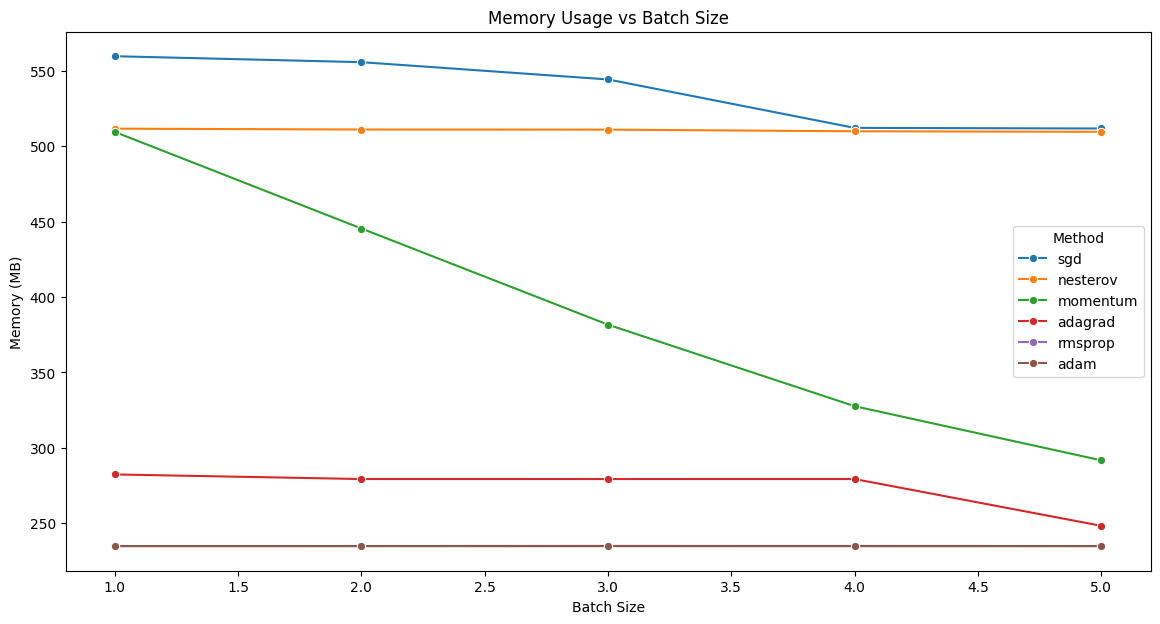

In [19]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Batch Size', y='Memory (MB)', hue='Method', marker='o')
plt.title('Memory Usage vs Batch Size')
plt.show()

## Delta Plot

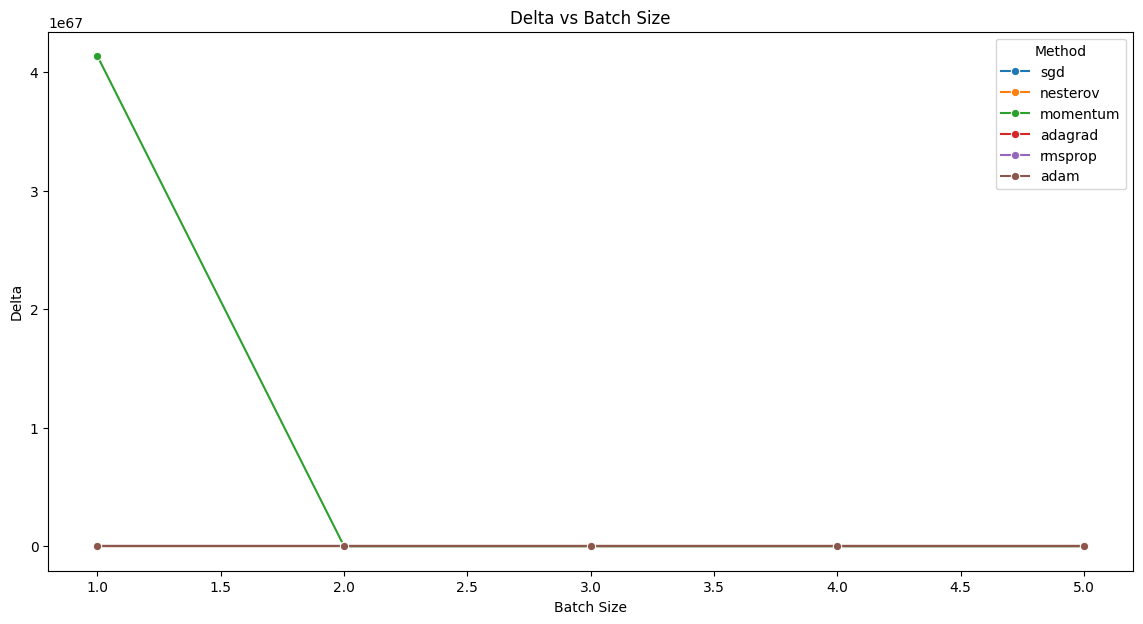

In [20]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Batch Size', y='Delta', hue='Method', marker='o')
plt.title('Delta vs Batch Size')
plt.show()

## Time Plot

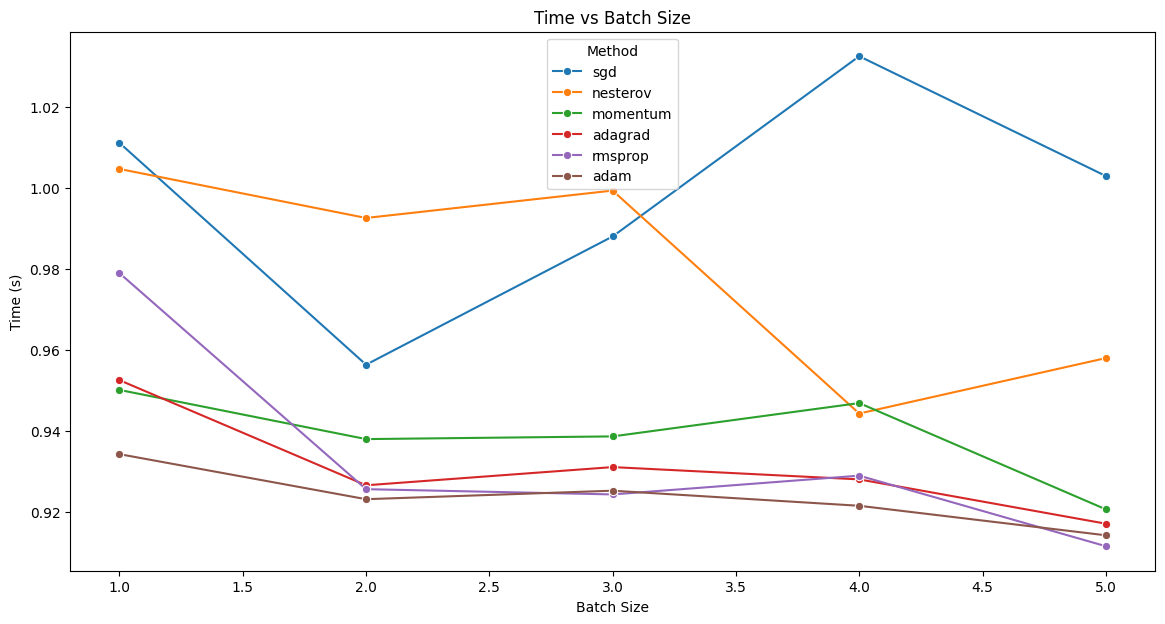

In [21]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Batch Size', y='Time (s)', hue='Method', marker='o')
plt.title('Time vs Batch Size')
plt.show()

## Regularizations

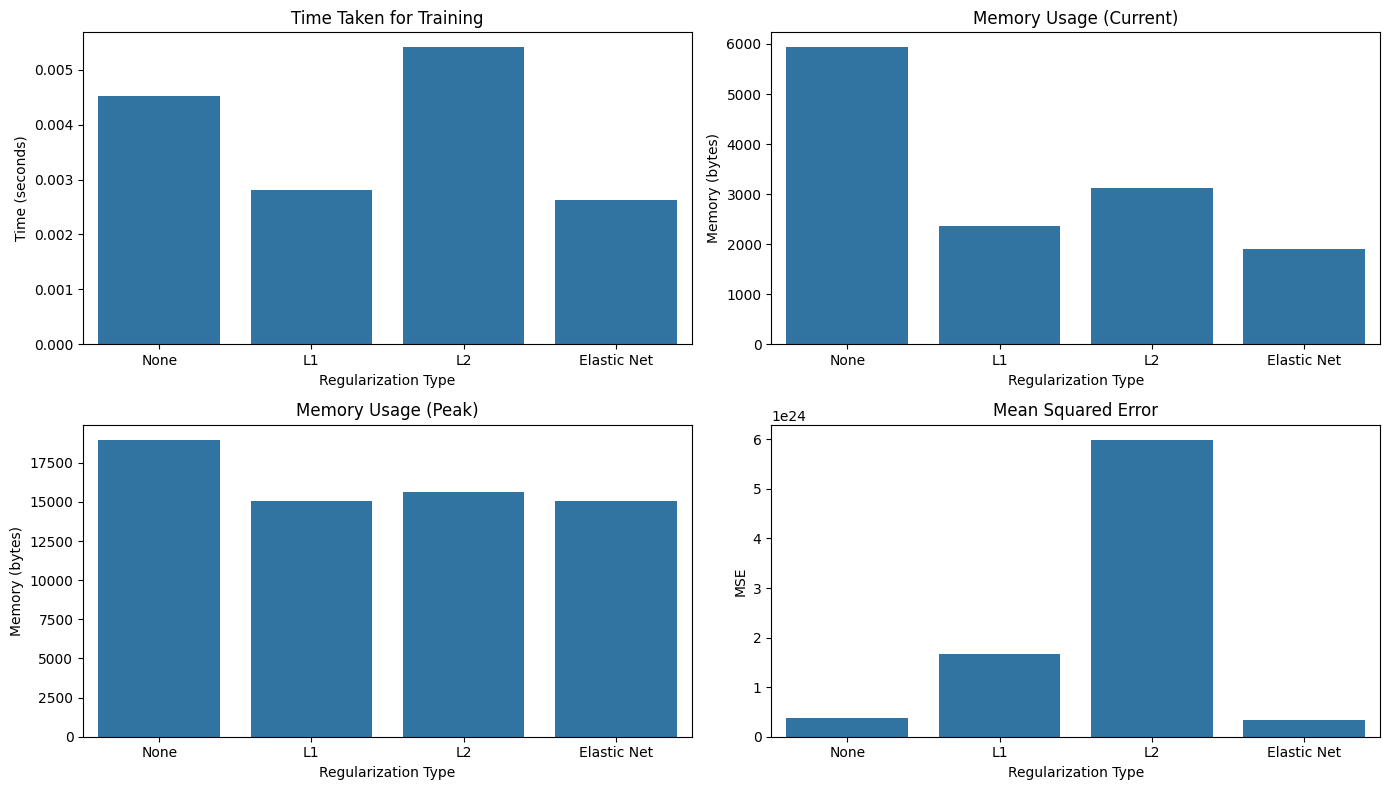

In [36]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tracemalloc


np.random.seed(0)
X = np.random.rand(100, 1) * 10
y = 2 * X**2 + 3 * X + np.random.randn(100, 1) * 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

degree = 2

results = []


def evaluate_model(pipeline, X_train, y_train, X_test, y_test, regularization_type):
    start_time = time.time()
    tracemalloc.start()
    
    pipeline.fit(X_train, y_train.ravel())
    
    current, peak = tracemalloc.get_traced_memory()
    end_time = time.time()
    
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    results.append({
        'Regularization': regularization_type,
        'Time Taken': end_time - start_time,
        'Memory Usage (current)': current,
        'Memory Usage (peak)': peak,
        'MSE': mse
    })
    
    tracemalloc.stop()

# No regularization
pipeline = make_pipeline(PolynomialFeatures(degree), SGDRegressor(penalty=None, max_iter=1000, tol=1e-3))
evaluate_model(pipeline, X_train, y_train, X_test, y_test, 'None')

# L1 regularization
pipeline = make_pipeline(PolynomialFeatures(degree), SGDRegressor(penalty='l1', max_iter=1000, tol=1e-3))
evaluate_model(pipeline, X_train, y_train, X_test, y_test, 'L1')

# L2 regularization
pipeline = make_pipeline(PolynomialFeatures(degree), SGDRegressor(penalty='l2', max_iter=1000, tol=1e-3))
evaluate_model(pipeline, X_train, y_train, X_test, y_test, 'L2')

# Elastic Net regularization
pipeline = make_pipeline(PolynomialFeatures(degree), SGDRegressor(penalty='elasticnet', max_iter=1000, tol=1e-3))
evaluate_model(pipeline, X_train, y_train, X_test, y_test, 'Elastic Net')

results_df = pd.DataFrame(results)

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='Regularization', y='Time Taken', data=results_df)
plt.title('Time Taken for Training')
plt.xlabel('Regularization Type')
plt.ylabel('Time (seconds)')

plt.subplot(2, 2, 2)
sns.barplot(x='Regularization', y='Memory Usage (current)', data=results_df)
plt.title('Memory Usage (Current)')
plt.xlabel('Regularization Type')
plt.ylabel('Memory (bytes)')

plt.subplot(2, 2, 3)
sns.barplot(x='Regularization', y='Memory Usage (peak)', data=results_df)
plt.title('Memory Usage (Peak)')
plt.xlabel('Regularization Type')
plt.ylabel('Memory (bytes)')

plt.subplot(2, 2, 4)
sns.barplot(x='Regularization', y='MSE', data=results_df)
plt.title('Mean Squared Error')
plt.xlabel('Regularization Type')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()
